In [1]:
import os
from pprint import pprint
import descarteslabs as dl
%matplotlib inline
import matplotlib.pyplot as plt
import shapely.geometry
# import cartopy
import json
import numpy as np

Fetch the geometry for Newport County, Rhode Island and extract the coordinates of the geometry for analysis. 

In [2]:
rhode_island = dl.places.find('rhode-island_newport')[0]
shape = dl.places.shape(rhode_island['slug'], geom='low')

Use the selected geometry to search for Landsat 8 imagery for a given time period. Push the matching images into an array for processing and analysis in this environment.

In [4]:
feature_collection = dl.metadata.search(products=['landsat:LC08:PRE:TOAR'], start_time='2016-06-01', 
    end_time='2016-06-30', limit=10, place=rhode_island['slug'])
ids = [f['id'] for f in feature_collection['features']]

arr, metadata = dl.raster.ndarray(
    ids,
    bands=['nir', 'swir1', 'red', 'alpha'],
    scales=[[0,6000], [0,6000], [0,6000], None],
    data_type='Byte',
    resolution=30,
    cutline=shape['geometry']
)

Display the raster data collected to see what they look like:

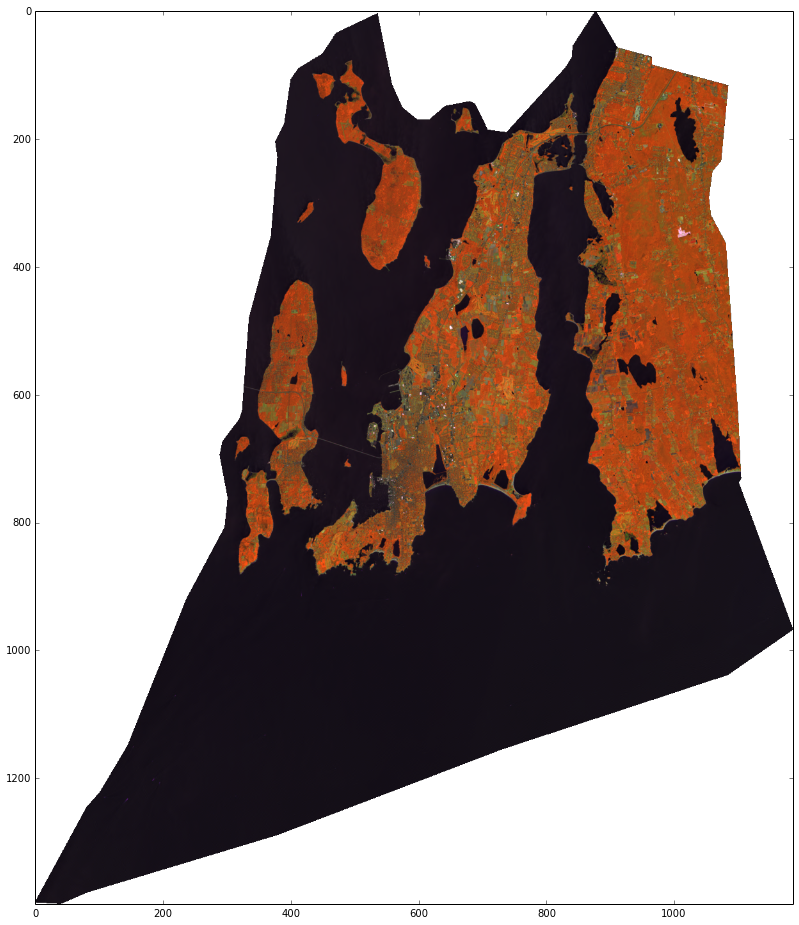

In [5]:
plt.figure(figsize=[16,16])
plt.imshow(arr)

Now that we have complete coverage for Rhode Island, let's write a simple method to remove the water from the scene.

In [6]:
def mask_water(raster):
    shape = raster.shape
    length = raster.size
    
    # Reshape the matrix to a vector
    x = raster.reshape(length)
    
    # Slice every 4th element
    # This selects all the nir values from the vector 
    y = x[0::4]
    
    # I think these can be done in a more simple way like this arr[:,:,0], give it a try after this works
    
    # Mask the output if less than 60 for NIR 
    # Create a vector of the same size as the NIR vector with all vals 60 for comparison
    sixty = np.ones(len(y))*60
    
    # Create a vector of boolean values, true when NIR is less than 60     
    z = y < sixty
       
    # Multiply by 4  - this will extend the bool vector by copying the value 4 times in place
    a = np.repeat(z, 4)
    
    # Compare the mask to the original raster vector: Returns the value where where false, and '--' where mask is true
    b = np.ma.masked_array(x,a)

    # Give masked nums the value of 0 
    b = np.ma.filled(b,0)
    
    # Push the output vector into its original 3D shape
    c = b.reshape(shape)
    return c

    

Apply the water mask method to the data and plot it:

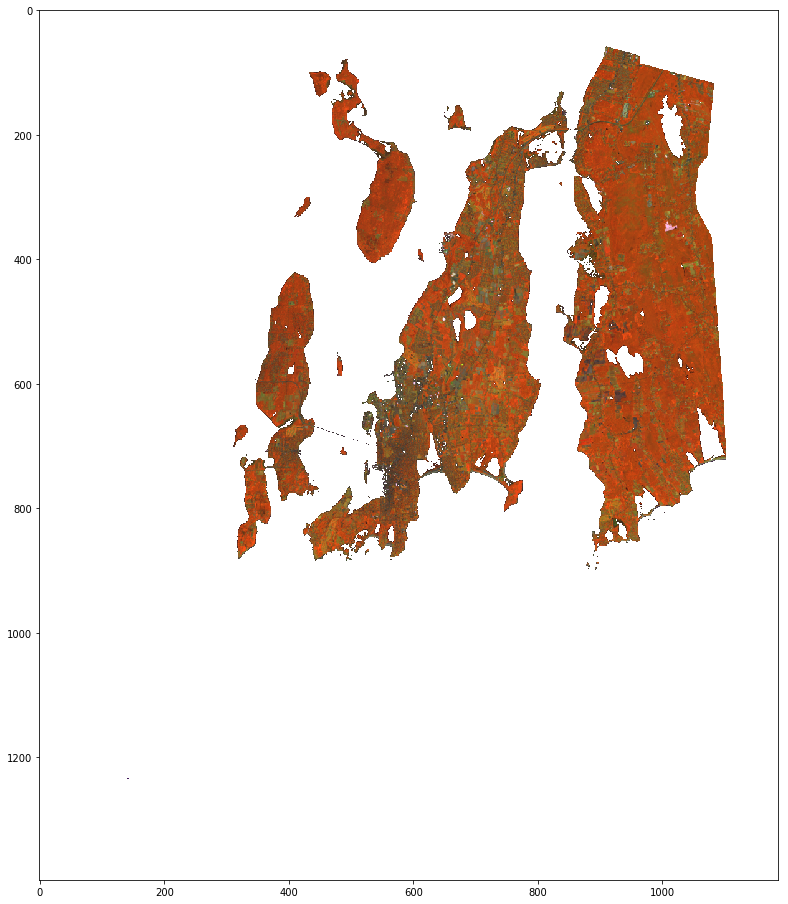

In [39]:
no_water = mask_water(arr)

plt.figure(figsize=[16,16])
plt.imshow(no_water)

In [7]:
from descarteslabs.client.services import Catalog


A simple function that counts all non_zero pixels, returning the total bumber of land-based pixels detected.

In [53]:
def get_land_area(image, area_per_pixel):
    # Flatten the rows, columns,and bands into a single array.      
    length =image.size
    flattened_image = image.reshape(length)
    
    # Select every fourth element, the fourth being the alpha band 
    # with a value of 0 for no valid data and 255 for valid data 
    alpha_values = flattened_image[3::4]
    
    land_pixels = np.count_nonzero(alpha_values)
    print("The total land area is {} meters squared.".format(land_pixels * area_per_pixel))
    
    return land_pixels * area_per_pixel
    
    

Return a summary of land pixels detected in Newport County. Lansat images are 30 meters high by 30 meters wide, so we use 900 as the variable for area per pixel. 

In [41]:
get_land_area(no_water, 900)

The total land area is 266893200 meters squared.


We can use the ```mask_water``` and ```get_land_area``` functions to run the exact same analysis over a larger area. Let's try all of Rhode Island. 

Given the expanded area of analysis, it is a good idea to break the region up into smaller, more managable parts. This is where DL Tiles come in handy. Using pthe DL tile functionality, we can break an area up given "places" API endpoint, a geojson, or a latitude and longitude. We begin in a similar fashion as we did for Newport County, by identifying a geometry of interest via our places API. The output is a feature collection of geometries.

In [42]:
rhode_island = dl.places.shape("north-america_united-states_rhode-island")
dl_tiles = dl.raster.dltiles_from_shape(30.0, 2048, 16, rhode_island)

Given our ability to adjust the resolution, the number of tiles returned in the feature collection can vary. 

In [43]:
print("The number of DL tiles generated for the state of Rhode Island at a 30 meter resolution is {}.".format(len(dl_tiles['features'])))

The number of DL tiles generated for the state of Rhode Island at a 30 meter resolution is 4.


We can even plot the DL tiles over with the State Boundary using the Cartopy library.

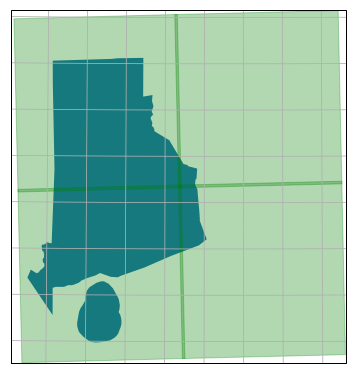

In [44]:
# Load in a few coordinate systems
long_lat = cartopy.crs.PlateCarree()
albers = cartopy.crs.AlbersEqualArea(central_latitude=41.0, central_longitude= -71)

# Create a plot and define its coordinate system.
fig = plt.figure(figsize=(6, 8))
ax= plt.subplot(projection=albers)

# Add the geometry for Rhode Island we defined using our Places API. 
ax.add_geometries([shapely.geometry.shape(rhode_island['geometry'])], long_lat)

# Add the geometries for the DL Tiles created 
# Iterate through the feature collection and create an array of shapely instances 
tile_shapes = [shapely.geometry.shape(f['geometry']) for f in dl_tiles['features']]
ax.add_geometries(tile_shapes, long_lat, alpha=0.3, color='green')

# Get a bounding box of the combined scenes
union = shapely.geometry.MultiPolygon(polygons=tile_shapes)
bbox = union.bounds
ax.set_extent((bbox[0], bbox[2], bbox[1], bbox[3]), crs=long_lat)
ax.gridlines(crs=long_lat)

plt.show()


Given a set of DL tiles, we can search for imagery that covers each tile. We can filter this search by date, cloud fraction, or any other metadata property. Let's define a function that searches for imagery given a DL tile and returns 

In [57]:
# Define a function that searches for imagery over a dl tile and returns a 
# plotted image.

def search_for_imagery_over_tile(dl_tile, start_date, end_date, whole_boundary):
    # Search for scenes give a time range, satellite product, and DL tile     
    images = dl.metadata.search(
                            products=["landsat:LC08:PRE:TOAR"],
                            start_time=start_date,
                            end_time=end_date,
                            geom=json.dumps(tile['geometry']),
                            cloud_fraction=0.2,
                            limit = 1000
                            )

    print('There are {} scenes for this tile.'.format(len(images['features'])))

    # Isolate the ids      
    ids = [image['id'] for image in images['features']]

    # Create an array of the matching scenes      
    arr, meta = dl.raster.ndarray(
        ids,
        bands=['nir', 'swir1', 'red', 'alpha'],
        scales=[[0,6000], [0, 6000], [0, 6000], None],
        data_type='Byte',
        srs = tile['properties']['cs_code'],
        resolution = tile['properties']['resolution'],
        bounds = tile['properties']['outputBounds'],
        cutline = cutline_geometry)



    # Remove the padded rows and columns added when generating the DL Tiles.
    arr = arr[16:-16, 16:-16]
    

    return [np.copy(arr),meta]  

Let's use the function we defined on the set of Rhode Island DL tiles we generated. 

There are 4 scenes for this tile.
The total land area is 925996500 meters squared.
There are 5 scenes for this tile.
The total land area is 1603639800 meters squared.
There are 4 scenes for this tile.
The total land area is 88194600 meters squared.
There are 2 scenes for this tile.
The total land area is 40501800 meters squared.
2658332700


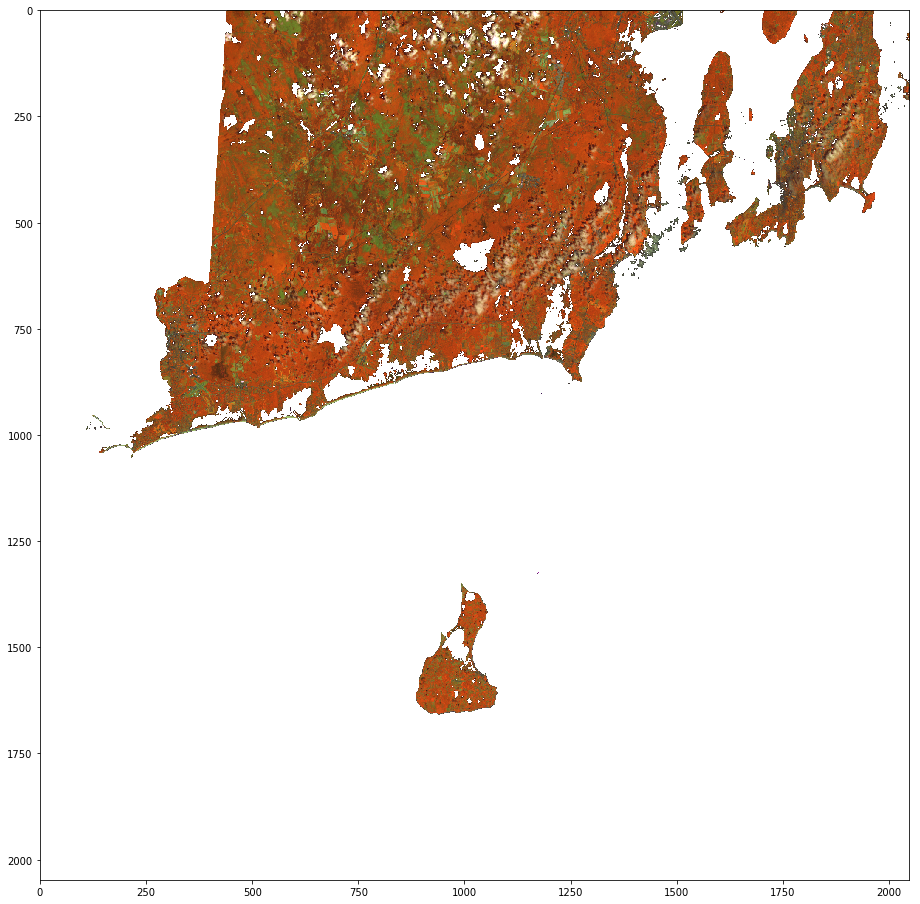

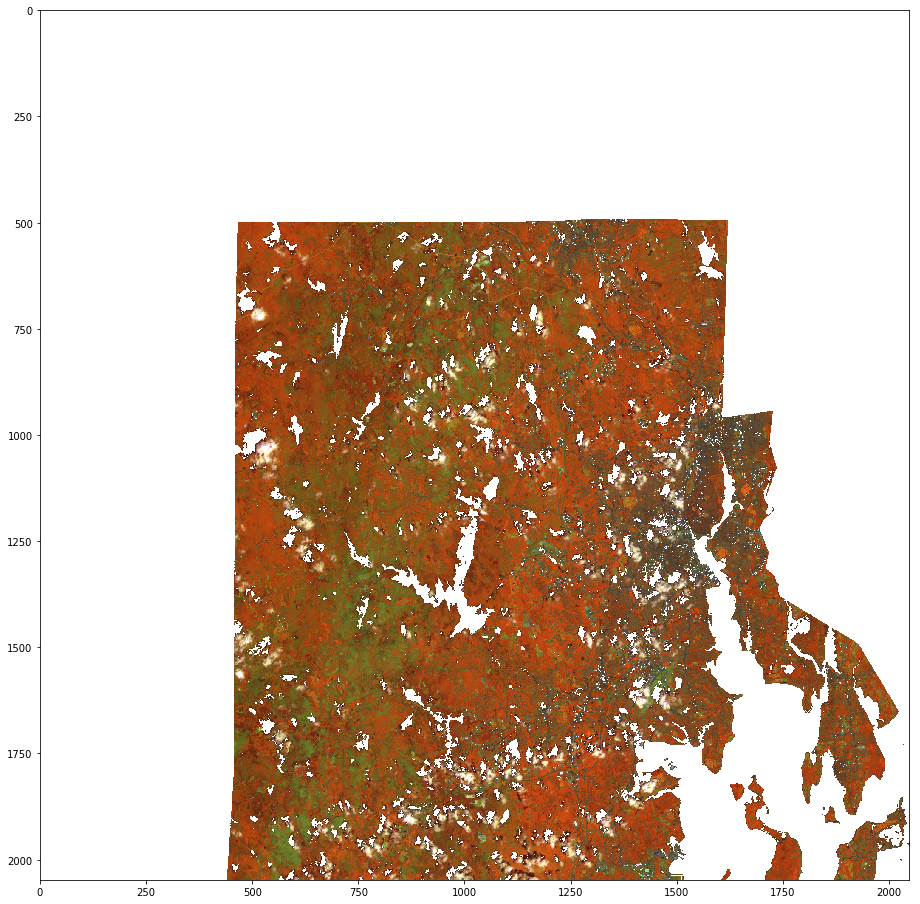

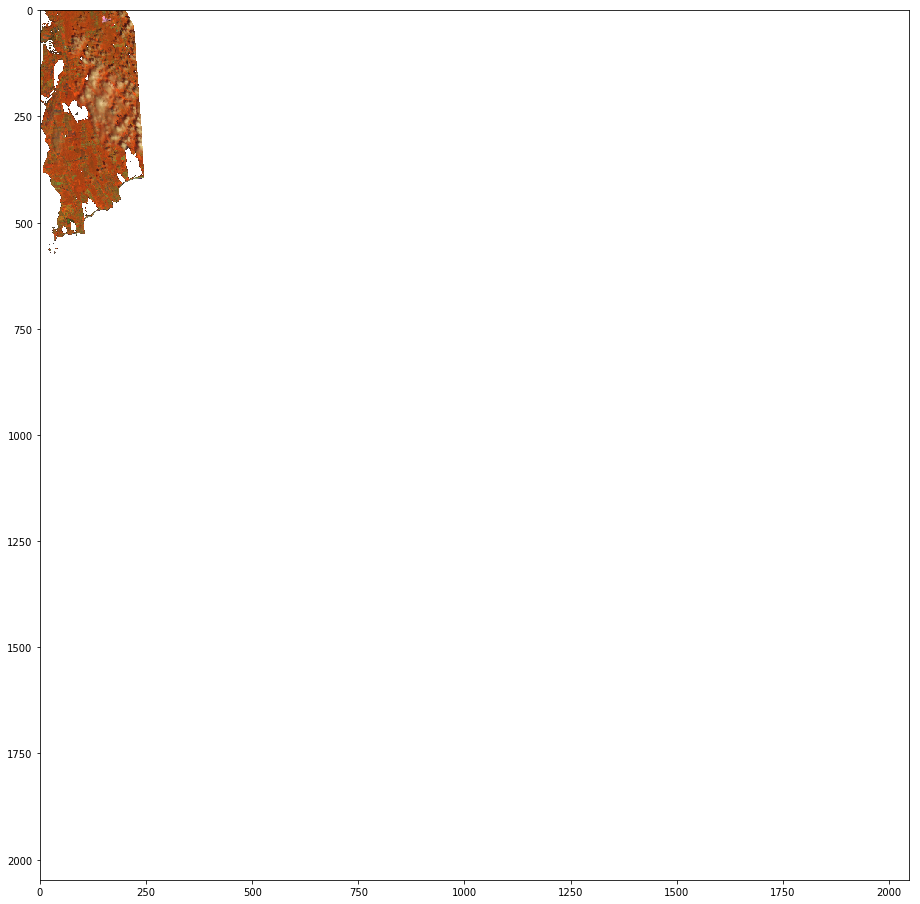

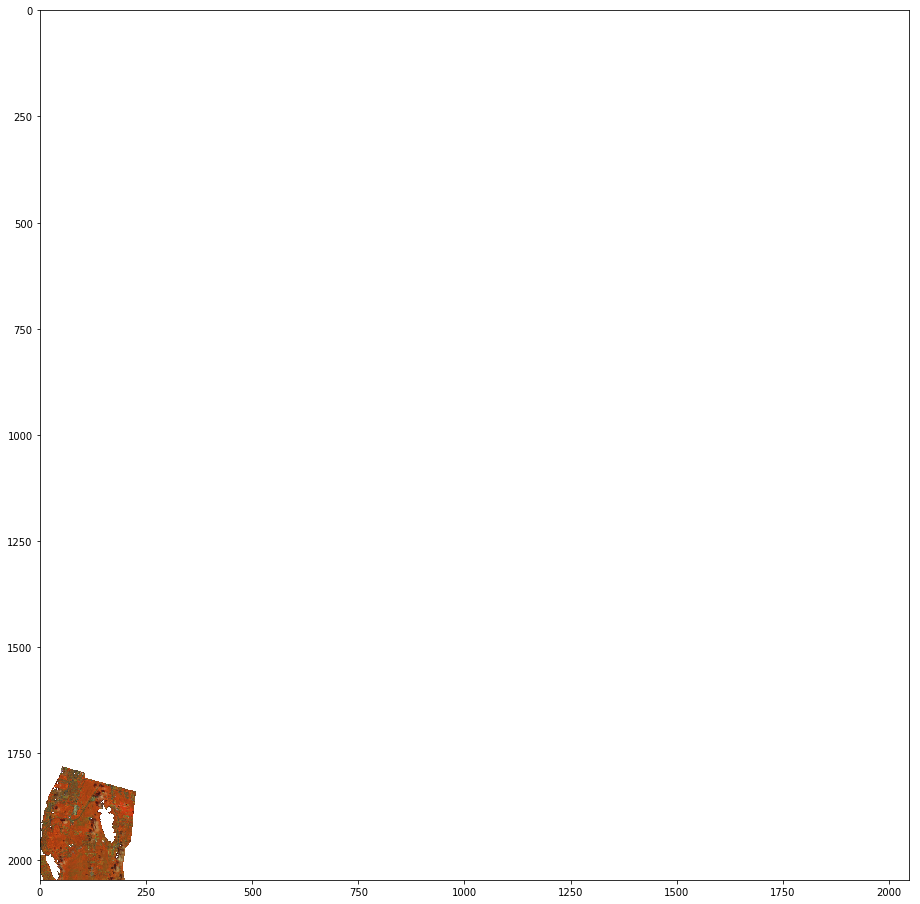

In [60]:
start_date = '2016-07-01'
end_date = '2016-07-31'
cutline_geometry = rhode_island['geometry']

# Create a counter for the final number of land pixels 
total_land_area = 0

# Iterate through the DL Tiles 
for tile in dl_tiles['features']:
    # Run the search for imagery over the tile. This returns an array.
    tile_array = search_for_imagery_over_tile(tile, start_date, end_date, cutline_geometry)

    # Run the water masking function on the array
    no_water_array = mask_water(tile_array[0])
    plt.figure(figsize=[16,16])
    plt.imshow(no_water_array)
    current_land_area = get_land_area(no_water_array, 900)
    total_land_area += current_land_area

print(total_land_area)